## Predicting Song Genres based on Audio Features

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics

##1) Data Exploration

In [19]:
songs = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')
songs

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,42,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432


In [16]:
songs.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

There are several columns that serve as identifiers. We will begin by dropping unnecessary variables. Then, drop any missing values.

In [20]:
songs = songs.drop(songs.columns[[0, 4, 5, 6, 7, 8]], axis=1)
songs.dropna()
songs.head()

,track_name,track_artist,track_popularity,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,Memories - Dillon Francis Remix,Maroon 5,67,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,All the Time - Don Diablo Remix,Zara Larsson,70,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


Let's take a look at the summary of the numeric columns:

In [21]:
songs.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


We see an outlier - there is a song with a duration_ms of 4000 (4 seconds long). Let's drop it.

In [22]:
songs = songs[songs['duration_ms'] != 4000]

Let's take a look at the distribution of songs across the genres and sub-genres.

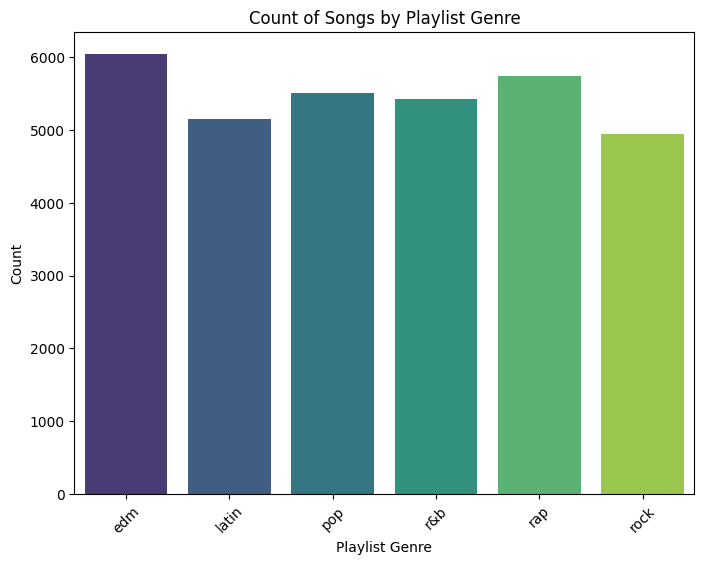

In [30]:
genre_summary = songs.groupby('playlist_genre').size().reset_index(name='Count')
plt.figure(figsize=(8, 6))
sns.barplot(x='playlist_genre', y='Count', data=genre_summary, palette='viridis', hue='playlist_genre', legend=False)

plt.title('Count of Songs by Playlist Genre')
plt.xlabel('Playlist Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

The songs seem to be evenly distributed among the 6 genres, which will strengthen our analysis.

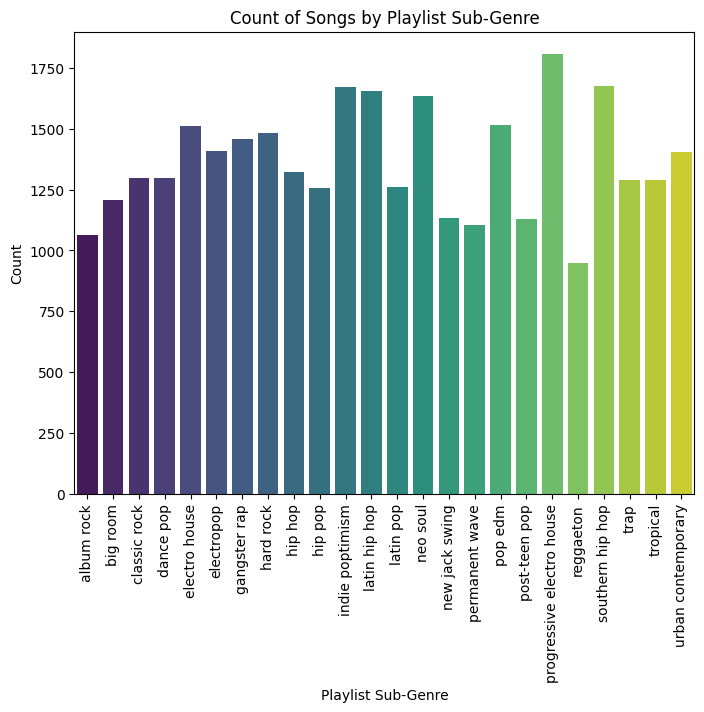

In [39]:
subgenre_summary = songs.groupby('playlist_subgenre').size().reset_index(name='Count')
plt.figure(figsize=(8, 6))
sns.barplot(x='playlist_subgenre', y='Count', data=subgenre_summary, palette='viridis', hue='playlist_subgenre', legend=False)

plt.title('Count of Songs by Playlist Sub-Genre')
plt.xlabel('Playlist Sub-Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

In [34]:
songs.groupby(['playlist_genre', 'playlist_subgenre']).size().reset_index(name='Count')

,playlist_genre,playlist_subgenre,Count
0,edm,big room,1206
1,edm,electro house,1511
2,edm,pop edm,1517
3,edm,progressive electro house,1809
4,latin,latin hip hop,1656
5,latin,latin pop,1262
6,latin,reggaeton,949
7,latin,tropical,1288
8,pop,dance pop,1298
9,pop,electropop,1408


Now, let's dive into the audio features, starting by plotting the distribution of each feature:

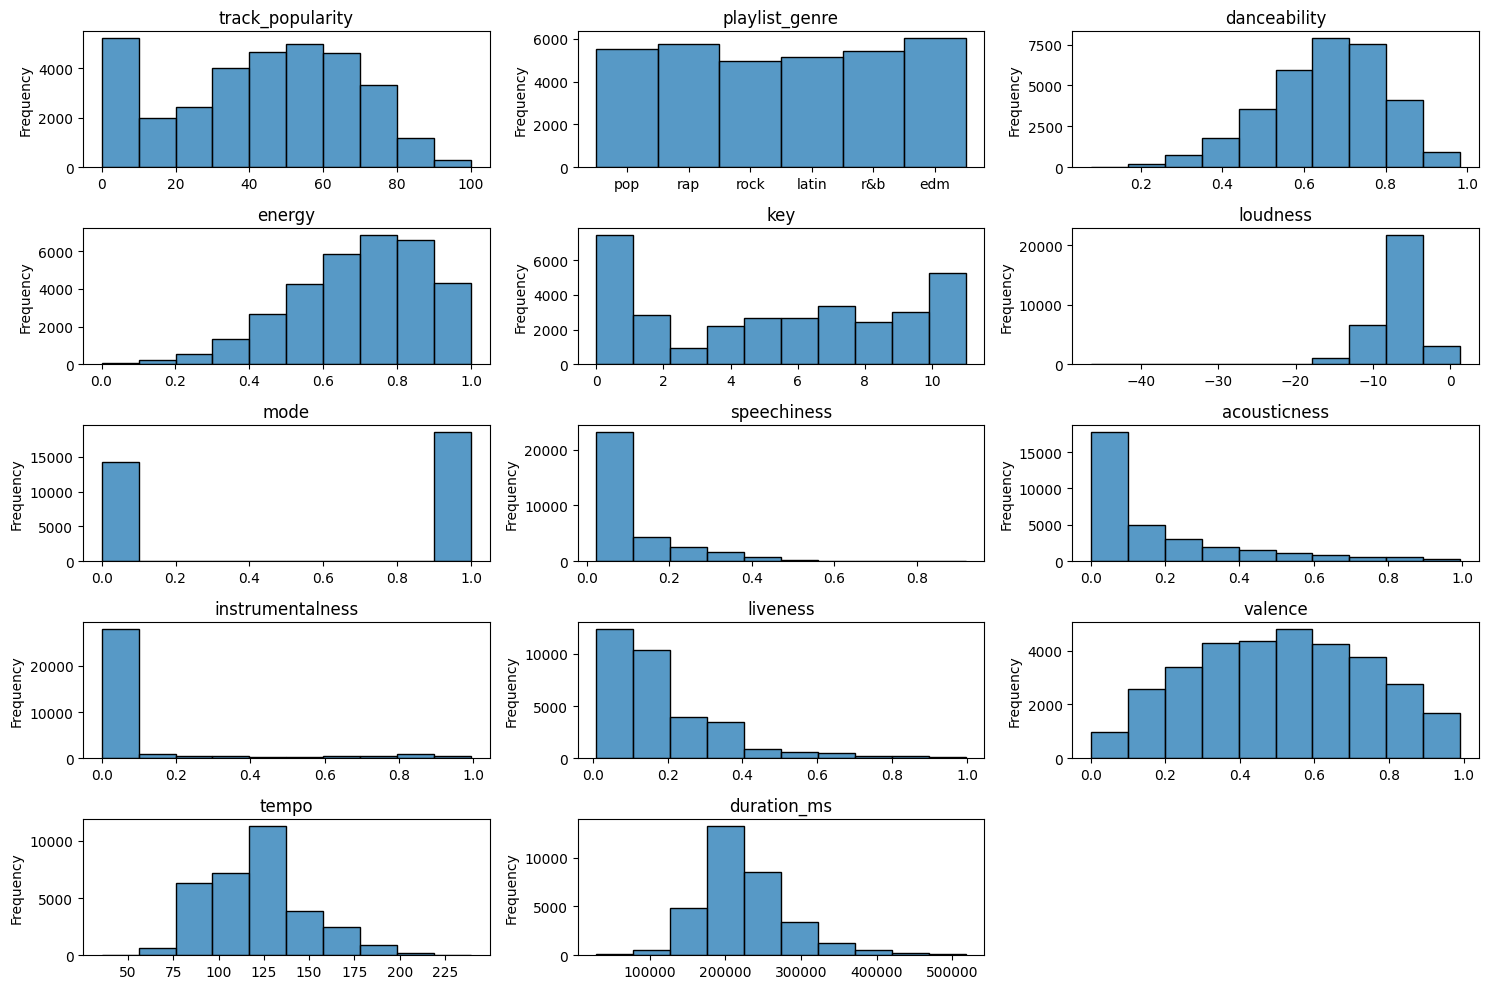

In [46]:
#Subset the data to just the audio features
features =  songs.drop(songs.columns[[0, 1, 4]], axis=1)

plt.figure(figsize=(15, 10))

# Plot histograms for each feature
for i, column in enumerate(features.columns):
    plt.subplot(5, 3, i + 1)  # Adjust the grid size as needed
    sns.histplot(features[column], bins=10, kde=False)
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Correlations between audio features:

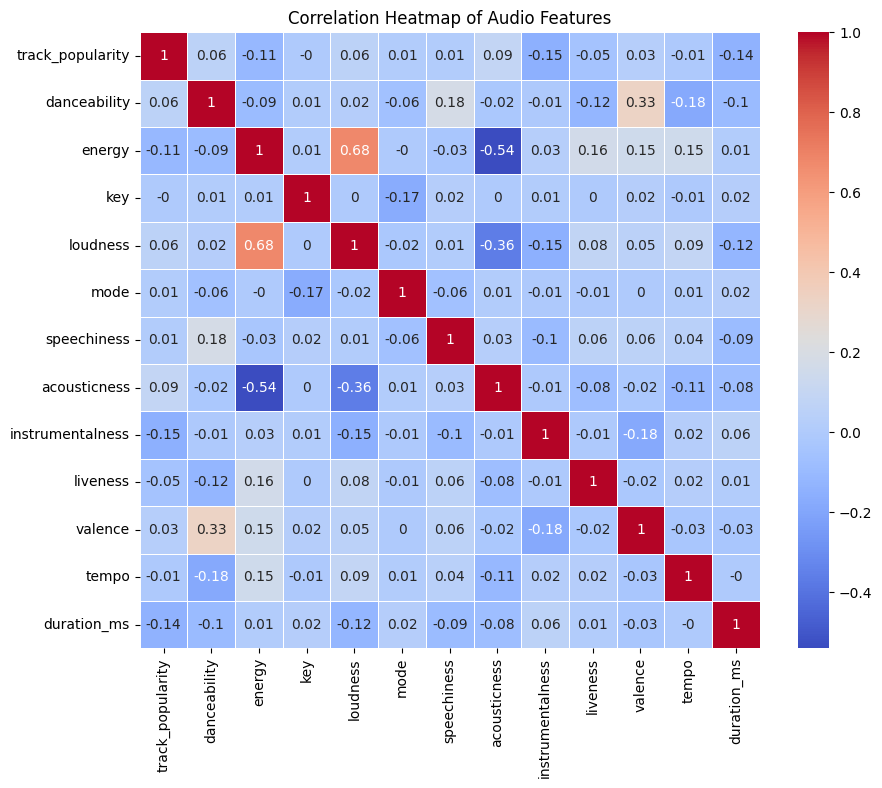

In [47]:
#create a correlation matrix
cm = features.drop(features.columns[1], axis=1).corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Audio Features')
plt.show()

The correlations between most of the features are low. The strongest relationships appear to be between 1) energy and loudness (0.68) and 2) energy and acousticness (-0.54). This makes sense! Louder songs tend to feel higher-energy. Acoustic songs have more of a chill low-energy vibe.

This tells us that we may need to drop the energy variable to avoid multicollinearity when training the prediction model.

Now, we should analyze the patterns of audio features across the different genres.

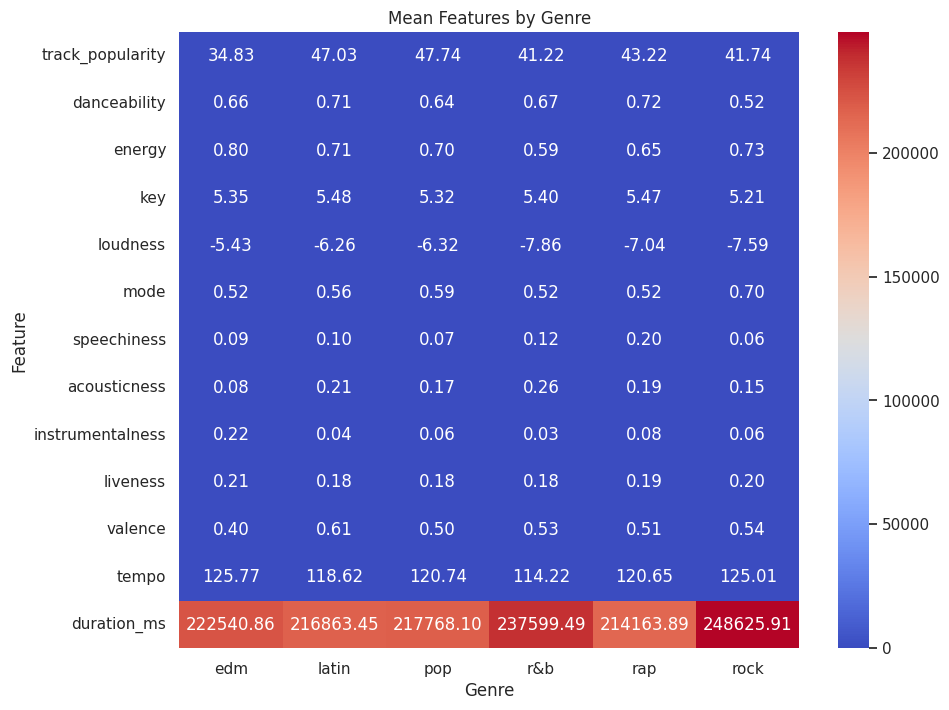

In [88]:
mean_features = features.groupby('playlist_genre').mean().reset_index()

plt.figure(figsize=(10, 8))
sns.heatmap(mean_features.set_index('playlist_genre').T, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mean Features by Genre')
plt.xlabel('Genre')
plt.ylabel('Feature')
plt.show()

Insights:
- Rap and Latin are the more danceable genres.
- EDM is higher energy while R&B is the lowest. This pattern is repeated with loudness and tempo.
- Latin has higher valence while EDM has the lowest.
- Rap has the highest speechiness while rock has the lowest.

Kernel density estimation (KDE) plots provide a good visualization of the variations between genres:

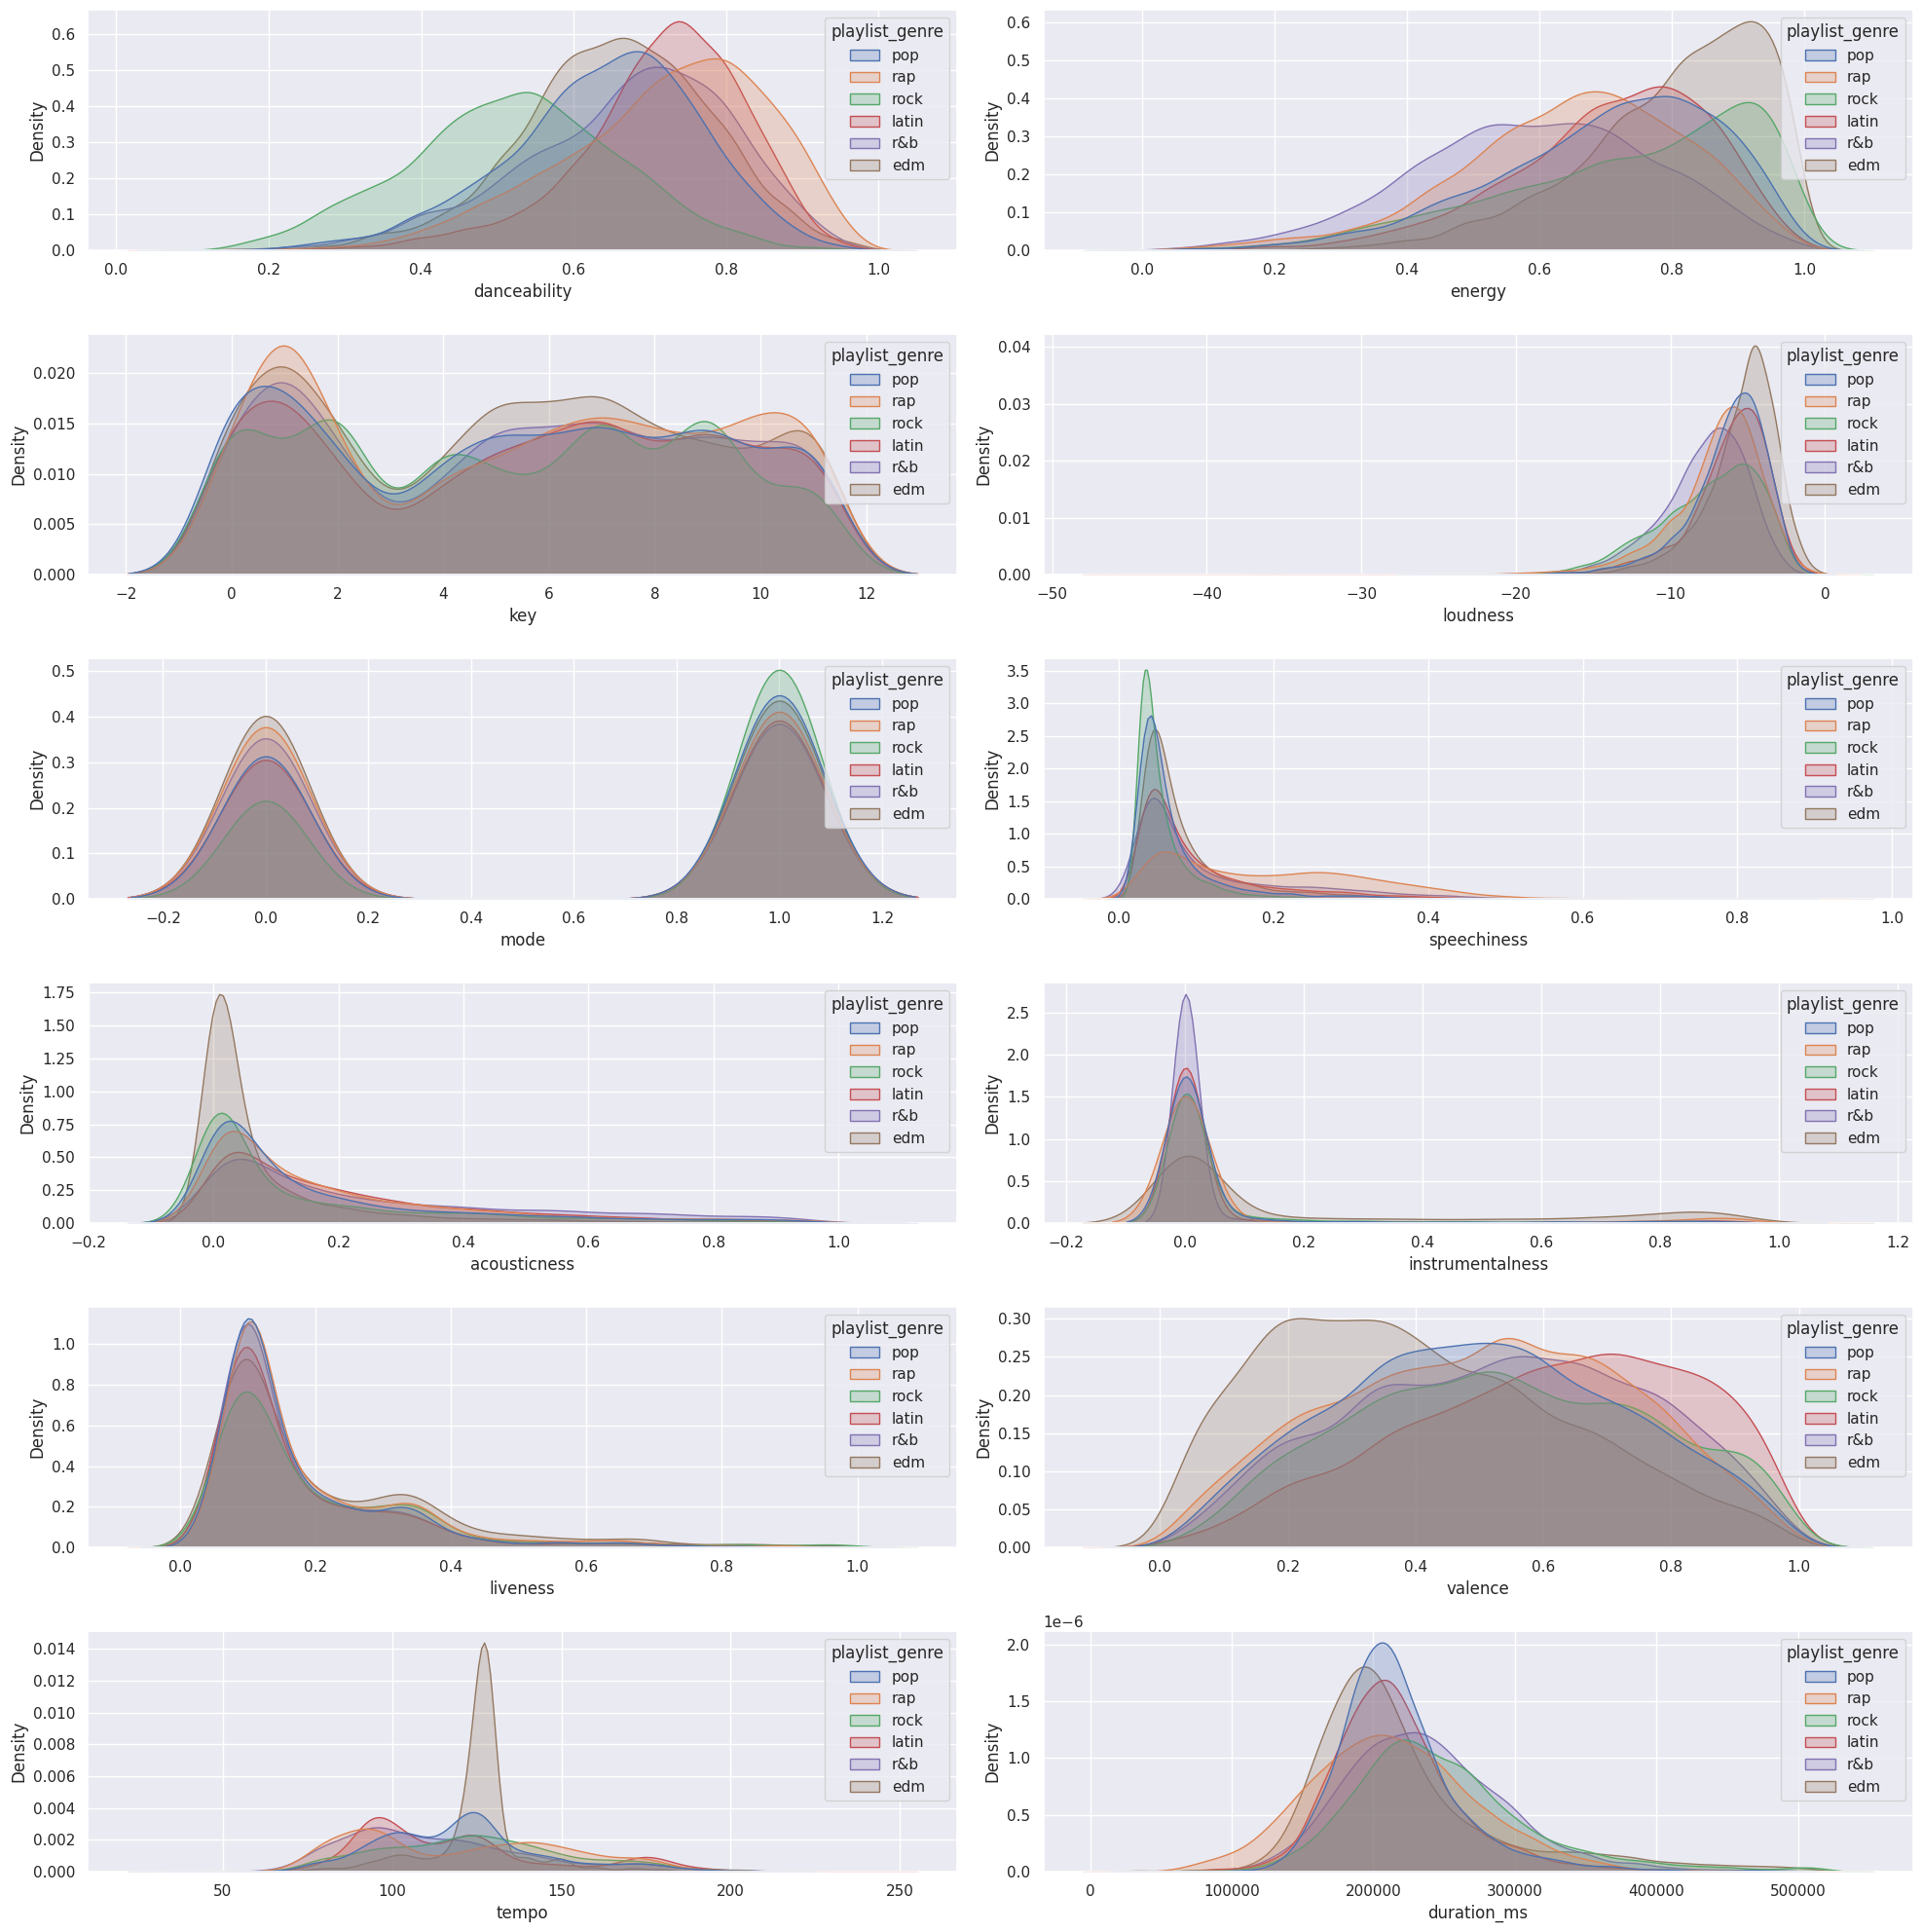

In [86]:
fig, axes = plt.subplots(6, 2, figsize=(20, 20))
axes = axes.flatten()
for i, feature in enumerate(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']):
  sns.kdeplot(data=features, x=feature, hue='playlist_genre', fill=True, ax=axes[i])

plt.tight_layout()

plt.show()

There does not appear to be significant variations across the genres in terms of liveness, mode, and key. This tells us that these features may not be the most useful for distinguishing between genres. Now we can begin training the prediction model!

## 2) Training Models

Begin by splitting the data into a training set and a test set. The commonly used ratio for splitting data is 80% train and 20% test. Encode the target y variable (playlist_genre).

In [92]:
num_cols = songs.select_dtypes(include='number').columns
X = songs[num_cols]
y = songs['playlist_genre']

le = LabelEncoder().fit(y)
y = pd.Series(le.transform(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

print("Training data size : {}, Test data size {} ".format(X_train.shape, X_test.shape))

Training data size : (26265, 13), Test data size (6567, 13) 


In [93]:
#Class frequencies
y_train.value_counts()

,count
0,4869
4,4628
2,4403
3,4339
1,4116
5,3910


Feature Selection:
- What features are more strongly associated with genre? Using mutual information will tell us how important each audio feature is by measuring the association.

<Axes: >

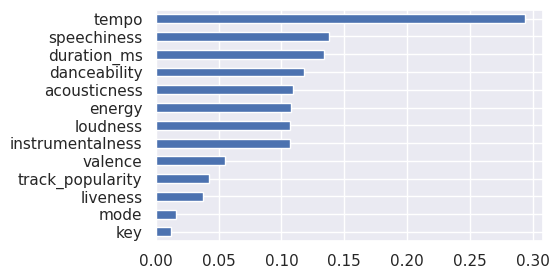

In [95]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info, X_train.columns).sort_values()

sns.set(rc = {'figure.figsize':(5,3)})
mutual_info.plot(kind='barh')

As predicted from the density plots, liveness, mode, and key are not strong predictors of genre.

We will drop these variables, as well as energy, from the dataset. Remember from the correlation matrix that energy had relatively high correlations with acousticness and loudness. Dropping energy will prevent multicollinearity.

In [96]:
X_train.drop(columns=['energy', 'liveness', 'mode', 'key'],axis=1, inplace=True)
X_test.drop(columns=['energy', 'liveness', 'mode', 'key'],axis=1, inplace=True)

In [116]:
print(X_train.columns) #Final features

Index(['danceability', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'valence', 'tempo', 'duration_ms'],
      dtype='object')


**Initial Model Training:**

We will train multiple classification algorithms to find the most accurate one.

Begin by creating a pipeline to standardize the numeric data and then train the models with cross-validation and manually selecting some hyperparameter values.

In [104]:
#The classification algorithms we will test:
clfs = [
    LogisticRegression(max_iter=200, C=0.5, random_state=54),
    SVC(random_state=54),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=54),
    RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=5, random_state=54),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=54),
    XGBClassifier(n_estimators=300, random_state=54)
]

for classifier in clfs:
  # Create a pipeline for each classifier
  pipeline = make_pipeline(
      StandardScaler(),
      classifier
  )

  pipeline.fit(X_train, y_train)

  scores = cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True)

  print(str(classifier))
  print("Train accuracy : ", scores['train_score'].mean(), "CV accuracy : ",  scores['test_score'].mean())

LogisticRegression(C=0.5, max_iter=200, random_state=54)
Train accuracy :  0.45273177232057876 CV accuracy :  0.4523510375023796
SVC(random_state=54)
Train accuracy :  0.5477060727203502 CV accuracy :  0.5231677136874168
KNeighborsClassifier()
Train accuracy :  0.6205882352941178 CV accuracy :  0.4522748905387398
DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=54)
Train accuracy :  0.48103940605368367 CV accuracy :  0.44858176280220824
RandomForestClassifier(max_depth=7, min_samples_split=5, random_state=54)
Train accuracy :  0.5442128307633733 CV accuracy :  0.5122786978869218
GradientBoostingClassifier(learning_rate=0.05, random_state=54)
Train accuracy :  0.555216067009328 CV accuracy :  0.5255663430420712
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, f

XGBClassifier has the highest CV accuracy (0.536). Notice that the train accuracy is 0.946, indicating that it is overfitted to the training data.

Hyperparameter tuning can help reduce model complexity. We will use GridSearch to find the best combination of parameters and select the best model based on the F1 score.

In [108]:
#Create a new pipeline, no need to scale with XGBClassifier
pipeline = make_pipeline(
    XGBClassifier()
)

from sklearn.model_selection import GridSearchCV
params = {
    'xgbclassifier__learning_rate': [0.3, 0.5],
    'xgbclassifier__max_depth': [2, 3],
    'xgbclassifier__min_child_weight': [5, 10],
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__gamma': [1, 2],
    'xgbclassifier__colsample_bytree': [0.5, 0.8],
    'xgbclassifier__colsample_bytree': [0.8, 1.0],
}
grid_search = GridSearchCV(estimator=pipeline, param_grid=params, scoring="f1_macro", n_jobs=1, cv=3, error_score="raise", verbose=2)


grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=5, xgbclassifier__n_estimators=100; total time=   3.7s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=5, xgbclassifier__n_estimators=100; total time=   0.8s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=5, xgbclassifier__n_estimators=100; total time=   0.8s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=5, xgbclassifier__n_estimators=200; total time=   1.3s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__g

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=1,
             param_grid={'xgbclassifier__colsample_bytree': [0.8, 1.0],
                         'xgbclassifier__gamma': [1, 2],
                         'xgbclassifier__learning_rate': [0.3, 0.5],
                         'xgbclassifier__max_depth': [2, 3],
                         'xgbclassifier__min_child_weight': [5, 10],
                         'xgbclassifier__n_estimators': [100, 200, 300]},
             scoring='f1_macro', verbose=2)

In [109]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n

The best model returns an F1 score of 0.534, which isn't ideal. If we had access to additional audio features, adding them may improve accuracy. For now, we'll stick with this model and evaluate it on the test data.

## 3) Model Evaluation

In [119]:
#predict on test set using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

#convert the predicted target variables (encoded) to its original form.
y_pred_original = le.inverse_transform(y_pred)
y_test_original = le.inverse_transform(y_test)

Create a function to generate the results and a confusion matrix to evaluate our model.

In [120]:
def evaluate(pipeline, y_test_original, y_pred_original, show=True):
  if show:
      print(metrics.classification_report(y_test_original, y_pred_original, digits=3))


      fig, ax = plt.subplots(figsize=(12, 8))
      plt.grid(False)
      cm = confusion_matrix(y_test_original, y_pred_original)
      cmp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test_original))
      cmp.plot(ax=ax)

      plt.show();
  else:
      rep  = metrics.classification_report(y_test_original, y_pred_original, digits=3,  output_dict=True)
      df_rep = pd.DataFrame(rep).transpose()
      return df_rep

              precision    recall  f1-score   support

         edm      0.655     0.683     0.669      1174
       latin      0.493     0.403     0.444      1039
         pop      0.385     0.367     0.376      1104
         r&b      0.475     0.419     0.445      1092
         rap      0.581     0.666     0.621      1118
        rock      0.634     0.727     0.677      1040

    accuracy                          0.546      6567
   macro avg      0.537     0.544     0.539      6567
weighted avg      0.538     0.546     0.540      6567



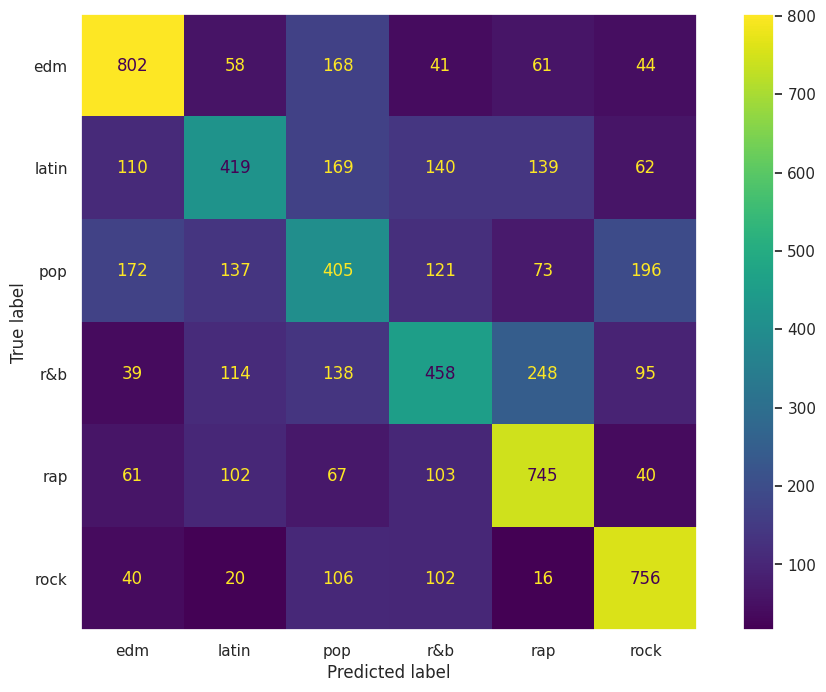

In [123]:
evaluate(grid_search, y_test_original, y_pred_original)

The overall accuracy is 0.546. In this case, model selection did not improve accuracy.

Even though this result isn't ideal, it's interesting to look at the accuracy by genre. EDM, rock, and rap report the highest F1 scores, indicating that they are easier to predict based on audio features.

The confusion matrix also reveals some interesting insights. The most commonly misclassified genre is r&b, labeled as rap, likely because these genres share similar audio features. What surprises me is how often pop is misclassified as rock. I'd expect these genres to be more distinguishable.

In conclusion, some genres are more easily distinguishable than others. Next steps for model improvement will be using different input data with a larger variety of genres, perhaps scraped directly from the Spotify API.